In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import time

# MINST

## Data Loading

In [2]:
mean,std = 0,1
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([mean],[std])])

In [3]:
nbatch = 5
trainset = torchvision.datasets.MNIST(root="./MNISTdataset",train=True,download=True,transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset,batch_size=nbatch,shuffle=True,num_workers=2) # no idea what shuffle and nworkers do
testset = torchvision.datasets.MNIST(root="./MNISTdataset",train=False,download=True,transform=transform)
testLoader =  torch.utils.data.DataLoader(testset,batch_size=nbatch,shuffle=True,num_workers=2) 

0 3 9 7 5


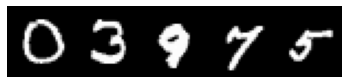

In [5]:
def imshow(img):
    img = img*std + mean
    npimg = img.numpy()
    plt.axis("off")
    npimg = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg)
    plt.show
    
dataiter = iter(trainLoader)
images,labels = dataiter.next()

# print(images.shape)
imshow(torchvision.utils.make_grid(images))

print(" ".join(str(labels[j].numpy()) for j in range(nbatch)))

#### First of All: Relationship between input and output sizes.

* **Input**: W1xH1xD1
    * Filter size: FxF
    * Number of Filters: K
    * Stride: S
    * (zero) Padding: P
* **Output**: W2xH2xD2
    * W2 = (W1 - F + 2P)/S + 1
    * H2 = (H1 - F + 2P)/S + 1
    * D2 = K
    

## Architecture

* Input: nbatchesx1x28x28
* ReLu of Conv2D with K = 6 F = 3 S = 1 P = 0: $\rightarrow$ nbatchesx6x26x26
* ReLu of MaxPool2D with 2x2: $\rightarrow$ nbatchesx6x13x13
* ReLu of Conv2D with K: = 16 F = 2 S = 1 P = 0: $\rightarrow$ nbatchesx16x12x12
* ReLu of MaxPool2D with 3x3:  $\rightarrow$ nbatchesx16x4x4
* Flatten: nbatchesx16x4x4: $\rightarrow$ nbatchesx256
* ReLu of Fully Connected: $\rightarrow$ nbatchesx128
* ReLu of Fully Connected: $\rightarrow$ nbatchesx64
* ReLu of Fully Connected: $\rightarrow$ nbatchesx10
  
  
* Loss Function:
        Cross Entropy Loss
* Optimizer:
        Stochastic Gradient Decent with learning rate = 0.0001 and momentum = 0.1

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.cL = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3)
        self.pL = nn.MaxPool2d(2)
        self.cL2 = nn.Conv2d(6,16,2)
        self.pL2 = nn.MaxPool2d(3)
        self.fL = nn.Linear(16*4*4,128)
        self.fL2 = nn.Linear(128,64)
        self.fL3 = nn.Linear(64,10)
    def forward(self,x):
        x = self.pL(F.relu(self.cL(x)))
#         print(x.shape)
        x = self.pL2(F.relu(self.cL2(x)))
#         print(x.shape)
        x = x.view(-1,16*4*4)
#         print(x.shape)
        x = F.relu(self.fL(x))
#         print(x.shape)
        x = F.relu(self.fL2(x))
#         print(x.shape)
        x = F.relu(self.fL3(x))
#         print(x.shape)
        return x

model = Net()

### To Do:
* Split trianing data in training and validation (will be done later)
    * looks like the built in methos by torch doesn-t help 
* Store losses so you can plot training curves
* Compute time each epoch takes

epoch: 0, i: 2000 / 12000 batches, running loss: 2.2259236247837544
epoch: 0, i: 4000 / 12000 batches, running loss: 1.1439541743434967
epoch: 0, i: 6000 / 12000 batches, running loss: 0.7233245826901402
epoch: 0, i: 8000 / 12000 batches, running loss: 0.6275781243389938
epoch: 0, i: 10000 / 12000 batches, running loss: 0.6013570441163901
epoch: 0, i: 12000 / 12000 batches, running loss: 0.5810205454144889
epoch time 1.152265985806783 : 9.135959148406982 s, Loss: 0.9838596826145442
epoch: 1, i: 2000 / 12000 batches, running loss: 0.3532726227766434
epoch: 1, i: 4000 / 12000 batches, running loss: 0.1325463449368617
epoch: 1, i: 6000 / 12000 batches, running loss: 0.11480394130855712
epoch: 1, i: 8000 / 12000 batches, running loss: 0.09252474997489844
epoch: 1, i: 10000 / 12000 batches, running loss: 0.08062447963885642
epoch: 1, i: 12000 / 12000 batches, running loss: 0.09360043342517747
epoch time 1.1873501499493917 : 11.241008996963501 s, Loss: 0.1445620953434991
epoch: 2, i: 2000 / 

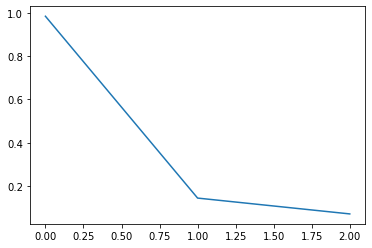

In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

running_loss =0
epoch_losses = []

for epoch in range(3):
    epoch_loss = 0
    start = time.time()
    for i,data in enumerate(trainLoader):
        images,labels = data
#         print(images.shape)
        optimizer.zero_grad()
        pred_labels = model(images)
        loss = criterion(pred_labels,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if(i%2000==1999): 
            epoch_loss += running_loss /2000
            print("epoch: {}, i: {} / {} batches, running loss: {}".format(epoch,i+1,12000,np.mean(running_loss/2000)))
            running_loss = 0
    epoch_losses.append(epoch_loss/6)
    epoch_time = time.time() - start
    print("epoch time {:.3f} : {:.3f} s, Loss: {:.3f}".format(epoch_time/ 60, epoch_time % 60,epoch_loss/6))
        
print("training completed")
plt.plot(epoch_losses)

predicted
7 1 1 6 3
true
7 1 1 6 3


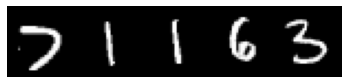

In [17]:
dataiter = iter(testLoader)
images,labels = dataiter.next()
with torch.no_grad():
    outs = model(images)

def imshow(img):
    img = img*std + mean
    npimg = img.numpy()
    plt.axis("off")
    npimg = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg)
    plt.show
    

pred_labels = torch.max(outs,1)[1]

# print(images.shape)
imshow(torchvision.utils.make_grid(images))
print("predicted")
print(" ".join(str(pred_labels[j].numpy()) for j in range(nbatch)))
print("true")
print(" ".join(str(labels[j].numpy()) for j in range(nbatch)))

In [22]:
labels.shape[0]

5

In [28]:
# checking accuracy
total,correct =0, 0
with torch.no_grad():
    for data in testLoader:
        images,labels = data
        outs = model(images)
        pred_labels = torch.max(outs.data,1)[1]
        total += labels.shape[0]
        correct += (pred_labels == labels).sum().item()

print("Accuracy of the network on the {} test images = {:.2f} %".format(testset.__len__(),100*correct/total))

Accuracy of the network on the 10000 test images = 98.42 %


In [30]:
# saving trained model:
# save trained model
PATH = "./MNIST_cnn.pth"
torch.save(model.state_dict(),PATH)

In [13]:
torch.max(pred_labels,1)[1]

tensor([2, 2, 9, 7, 4])

#### Testing from trained Model

predicted
0 6 9 6 0
true
0 6 9 6 0
Accuracy of the network on the 10000 test images = 98.42 %


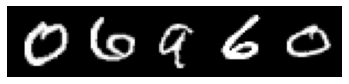

In [9]:
mean,std = 0,1
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([mean],[std])])

nbatch = 5
trainset = torchvision.datasets.MNIST(root="./MNISTdataset",train=True,download=True,transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset,batch_size=nbatch,shuffle=True,num_workers=2) # no idea what shuffle and nworkers do
testset = torchvision.datasets.MNIST(root="./MNISTdataset",train=False,download=True,transform=transform)
testLoader =  torch.utils.data.DataLoader(testset,batch_size=nbatch,shuffle=True,num_workers=2) 



import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.cL = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3)
        self.pL = nn.MaxPool2d(2)
        self.cL2 = nn.Conv2d(6,16,2)
        self.pL2 = nn.MaxPool2d(3)
        self.fL = nn.Linear(16*4*4,128)
        self.fL2 = nn.Linear(128,64)
        self.fL3 = nn.Linear(64,10)
    def forward(self,x):
        x = self.pL(F.relu(self.cL(x)))
#         print(x.shape)
        x = self.pL2(F.relu(self.cL2(x)))
#         print(x.shape)
        x = x.view(-1,16*4*4)
#         print(x.shape)
        x = F.relu(self.fL(x))
#         print(x.shape)
        x = F.relu(self.fL2(x))
#         print(x.shape)
        x = F.relu(self.fL3(x))
#         print(x.shape)
        return x

model = Net()

PATH = "./MNIST_cnn.pth"
model = Net()
model.load_state_dict(torch.load(PATH))

dataiter = iter(testLoader)
images,labels = dataiter.next()
with torch.no_grad():
    outs = model(images)

def imshow(img):
    img = img*std + mean
    npimg = img.numpy()
    plt.axis("off")
    npimg = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg)
    plt.show
    

pred_labels = torch.max(outs,1)[1]

# print(images.shape)
imshow(torchvision.utils.make_grid(images))
print("predicted")
print(" ".join(str(pred_labels[j].numpy()) for j in range(nbatch)))
print("true")
print(" ".join(str(labels[j].numpy()) for j in range(nbatch)))

# checking accuracy
total,correct =0, 0
with torch.no_grad():
    for data in testLoader:
        images,labels = data
        outs = model(images)
        pred_labels = torch.max(outs.data,1)[1]
        total += labels.shape[0]
        correct += (pred_labels == labels).sum().item()

print("Accuracy of the network on the {} test images = {:.2f} %".format(testset.__len__(),100*correct/total))